<a href="https://colab.research.google.com/github/firnanda-ra/projek-chatbot/blob/main/UTS_STKI_A11_2023_15373.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instal Sastrawi untuk stemming dan NLTK untuk stopwords
!pip install Sastrawi nltk

# Download database stopwords NLTK
import nltk
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.9 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PROJECT_PATH = '/content/drive/My Drive/STKI-UTS-A11.2023.15373-Firnanda'

# Buat semua folder yang dibutuhkan (mirip seperti Sel 2 Anda sebelumnya)
!mkdir -p "{PROJECT_PATH}/data"
!mkdir -p "{PROJECT_PATH}/src"
!mkdir -p "{PROJECT_PATH}/app"
!mkdir -p "{PROJECT_PATH}/notebooks"
!mkdir -p "{PROJECT_PATH}/reports"
!mkdir -p "{PROJECT_PATH}/requirements.txt"

print(f"Semua folder berhasil dibuat di dalam: {PROJECT_PATH}")

mkdir: cannot create directory ‘/content/drive/My Drive/STKI-UTS-A11.2023.15373-Firnanda/requirements.txt’: File exists
Semua folder berhasil dibuat di dalam: /content/drive/My Drive/STKI-UTS-A11.2023.15373-Firnanda


In [ ]:
PROJECT_PATH = '/content/drive/My Drive/STKI-UTS-A11.2023.15373-Firnanda'
%cd "{PROJECT_PATH}"
!ls -F

/content/drive/My Drive/STKI-UTS-A11.2023.15373-Firnanda
app/  data/  notebooks/  reports/  requirements.txt  src/


In [ ]:
!ls -l data/

total 12
-rw------- 1 root root  472 Nov  2 05:40 01_kos_griya_cendekia.txt
-rw------- 1 root root  440 Nov  2 05:41 02_wisma_bintang_pelajar.txt
-rw------- 1 root root  406 Nov  2 05:43 03_pondok_mahasiswa_jaya.txt
-rw------- 1 root root  430 Nov  2 05:43 04_kos_amanah_putri.txt
-rw------- 1 root root  442 Nov  2 05:43 05_graha_mandiri_residence.txt
-rw------- 1 root root  378 Nov  2 05:44 06_kos_pelangi.txt
-rw------- 1 root root  429 Nov  2 05:44 07_kos_eksklusif_emerald.txt
-rw------- 1 root root  388 Nov  2 05:44 08_wisma_melati.txt
-rw------- 1 root root  367 Nov  2 05:45 09_kos_dahlia_putra.txt
-rw------- 1 root root  419 Nov  2 05:45 10_kos_green_valley.txt
-rw------- 1 root root  321 Nov  2 05:46 11_kos_barokah.txt
-rw------- 1 root root  323 Nov  2 05:46 12_kos_simple_living.txt
-rw------- 1 root root  321 Nov  2 05:46 13_omah_nyaman.txt
-rw------- 1 root root  320 Nov  2 05:47 14_paviliun_cendana.txt
-rw------- 1 root root  262 Nov  2 05:47 15_kos_sahabat.txt
drwx------ 2 ro

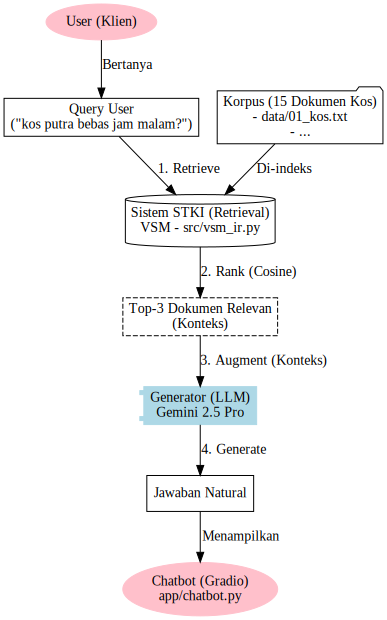

In [ ]:
#SOAL 1
import graphviz
dot = graphviz.Digraph(comment='Arsitektur RAG Chatbot Kos')
dot.attr(rankdir='TB')
dot.node('A', 'User (Klien)', shape='ellipse', style='filled', color='pink')
dot.node('B', 'Query User\n("kos putra bebas jam malam?")', shape='box')
dot.node('C', 'Sistem STKI (Retrieval)\nVSM - src/vsm_ir.py', shape='cylinder')
dot.node('D', 'Korpus (15 Dokumen Kos)\n- data/01_kos.txt\n- ...', shape='folder')
dot.node('E', 'Top-3 Dokumen Relevan\n(Konteks)', shape='box', style='dashed')
dot.node('F', 'Generator (LLM)\nGemini 2.5 Pro', shape='component', style='filled', color='lightblue')
dot.node('G', 'Jawaban Natural', shape='box')
dot.node('H', 'Chatbot (Gradio)\napp/chatbot.py', shape='ellipse', style='filled', color='pink')

dot.edge('A', 'B', label=' Bertanya')
dot.edge('B', 'C', label=' 1. Retrieve')
dot.edge('D', 'C', label=' Di-indeks')
dot.edge('C', 'E', label=' 2. Rank (Cosine)')
dot.edge('E', 'F', label=' 3. Augment (Konteks)')
dot.edge('F', 'G', label=' 4. Generate')
dot.edge('G', 'H', label=' Menampilkan')
dot

In [ ]:
# SOAL 2
%%writefile src/preprocess.py
import re
import string
import os
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords

# --- Inisialisasi Alat ---
try:
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    list_stopwords_nltk = set(stopwords.words('indonesian'))
    print("Stemmer dan stopwords berhasil dimuat untuk preprocess.py.")
except Exception as e:
    print(f"Gagal memuat Sastrawi/NLTK: {e}")
    stemmer = None
    list_stopwords_nltk = set()

# --- Fungsi-fungsi Preprocessing ---
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("","",string.punctuation))
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def tokenize(text):
    tokens = text.split()
    return tokens

def remove_stopwords(tokens):
    if not list_stopwords_nltk:
        return tokens
    clean_tokens = [token for token in tokens if token not in list_stopwords_nltk]
    return clean_tokens

def stem_tokens(tokens):
    if not stemmer:
        return tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

def preprocess_pipeline(text):
    """
    Fungsi pipeline lengkap untuk memproses satu string teks.
    """
    text_clean = clean_text(text)
    tokens = tokenize(text_clean)
    tokens_stopped = remove_stopwords(tokens)
    tokens_stemmed = stem_tokens(tokens_stopped)
    return ' '.join(tokens_stemmed)

Overwriting src/preprocess.py


In [ ]:
import src.preprocess as pp
import importlib
importlib.reload(pp) # Paksa Colab membaca ulang file .py

# --- Tampilkan Demo Before/After ---
print("--- DEMO PREPROCESSING (SOAL 2) ---")
try:
    with open('data/01_kos_griya_cendekia.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    print("--- BEFORE ---")
    print(text[:150] + "...") # Tampilkan 150 karakter pertama
    print("\n--- AFTER ---")
    print(pp.preprocess_pipeline(text)[:150] + "...")
except FileNotFoundError:
    print("ERROR: File 'data/01_kos_griya_cendekia.txt' tidak ditemukan.")
    print("Pastikan Anda sudah meng-upload 15 file .txt ke folder data/")

print("\n(Demo selesai. Tidak ada file yang disimpan.)")

Stemmer dan stopwords berhasil dimuat untuk preprocess.py.
Stemmer dan stopwords berhasil dimuat untuk preprocess.py.
--- DEMO PREPROCESSING (SOAL 2) ---
--- BEFORE ---
Nama: Kos Griya Cendekia
Alamat: Jl. Suka Maju No. 10, Tembalang, Semarang
Profil: Kos khusus putri, tenang, bersih, dan aman. Ideal untuk mahasiswi.
...

--- AFTER ---
nama kos griya cendekia alamat jl suka maju no tembalang semarang profil kos khusus putri tenang bersih aman ideal mahasiswi harga tipe a ac km rp tip...

(Demo selesai. Tidak ada file yang disimpan.)


In [ ]:
# SOAL 3
%%writefile src/boolean_ir.py
# Sel [9] (REVISI - eval.py)
# File ini: src/boolean_ir.py
import os
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import src.preprocess as pp  # Import modul preprocessing kita

# Inisialisasi stemmer (untuk query)
try:
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    print("Stemmer berhasil dimuat untuk boolean_ir.py.")
except Exception as e:
    print(f"Gagal memuat Sastrawi: {e}")
    stemmer = None

def build_inverted_index(data_dir_path):
    inverted_index = {}
    vocabulary = set()
    all_doc_ids = set()

    try:
        filenames = os.listdir(data_dir_path)
    except FileNotFoundError:
        print(f"ERROR: Folder {data_dir_path} tidak ditemukan.")
        return None, None, None

    print(f"Membangun index dari {len(filenames)} file di {data_dir_path}...")
    for filename in filenames:
        if filename.endswith('.txt'):
            doc_id = filename
            all_doc_ids.add(doc_id)
            file_path = os.path.join(data_dir_path, filename)

            with open(file_path, 'r', encoding='utf-8') as f:
                original_text = f.read()

            processed_text = pp.preprocess_pipeline(original_text)
            tokens = processed_text.split()

            vocabulary.update(tokens)

            for token in tokens:
                if token not in inverted_index:
                    inverted_index[token] = set()
                inverted_index[token].add(doc_id)

    return inverted_index, all_doc_ids, vocabulary

def get_postings(term, inverted_index):
    return inverted_index.get(term, set())

def parse_boolean_query(query_str, inverted_index, all_doc_ids):
    if not stemmer:
        print("Error: Stemmer tidak terinisialisasi.")
        return set()

    raw_tokens = query_str.lower().split()
    if len(raw_tokens) == 3:
        term1 = stemmer.stem(raw_tokens[0])
        op = raw_tokens[1].upper()
        term2 = stemmer.stem(raw_tokens[2])

        postings1 = get_postings(term1, inverted_index)
        postings2 = get_postings(term2, inverted_index)

        if op == 'AND':
            return postings1.intersection(postings2)
        elif op == 'OR':
            return postings1.union(postings2)
        elif op == 'NOT':
            return postings1.difference(postings2)
        else:
            return set() # Operator tidak dikenal
    else:
        processed_tokens = pp.preprocess_pipeline(query_str).split()
        if not processed_tokens:
            return set()
        return get_postings(processed_tokens[0], inverted_index)

# <-- Fungsi calculate_metrics SUDAH DIHAPUS DARI SINI -->

Overwriting src/boolean_ir.py


In [ ]:
import src.boolean_ir as bool_ir
import src.eval as eval_ir  # <-- TAMBAHKAN IMPORT INI
import importlib
importlib.reload(bool_ir)
importlib.reload(eval_ir)

print("--- MEMBANGUN INVERTED INDEX (SOAL 3) ---")
DATA_DIR = 'data/'
index, doc_ids, vocab = bool_ir.build_inverted_index(DATA_DIR)

if index:
    print(f"Index berhasil dibangun. Total {len(vocab)} term.")

    print("\n--- Uji Coba Parser ---")
    query1 = "putri AND malam"
    hasil1 = bool_ir.parse_boolean_query(query1, index, doc_ids)
    print(f"Hasil query '{query1}': {hasil1}")

    print("\n--- HASIL UJI WAJIB (EVALUASI) ---")
    gold_set = {
        "putri AND malam": {'01_kos_griya_cendekia.txt', '04_kos_amanah_putri.txt', '08_wisma_melati.txt', '13_omah_nyaman.txt'},
        "parkir AND mobil": {'02_wisma_bintang_pelajar.txt', '05_graha_mandiri_residence.txt', '07_kos_eksklusif_emerald.txt', '10_kos_green_valley.txt'},
        "ac AND dalam": {'01_kos_griya_cendekia.txt', '03_pondok_mahasiswa_jaya.txt', '04_kos_amanah_putri.txt', '05_graha_mandiri_residence.txt', '07_kos_eksklusif_emerald.txt', '09_kos_dahlia_putra.txt', '10_kos_green_valley.txt', '12_kos_simple_living.txt', '14_paviliun_cendana.txt'}
    }
    queries_to_test = ["putri AND malam", "parkir AND mobil", "ac AND dalam"]
    for query in queries_to_test:
        result_set = bool_ir.parse_boolean_query(query, index, doc_ids)
        current_gold_set = gold_set.get(query, set())

        # --- REVISI: Panggil dari eval_ir ---
        precision, recall, f1 = eval_ir.calculate_precision_recall_f1(result_set, current_gold_set)

        print(f"\nQuery: '{query}'")
        print(f"  > Hasil Sistem ({len(result_set)} docs): {result_set}")
        print(f"  > Kunci Jawaban ({len(current_gold_set)} docs): {current_gold_set}")
        print(f"  > Precision: {precision:.2f}")
        print(f"  > Recall: {recall:.2f}")
        print(f"  > F1-Score: {f1:.2f}")
else:
    print("\nGAGAL menjalankan Soal 3 karena index tidak terbangun.")

Stemmer berhasil dimuat untuk boolean_ir.py.
Stemmer berhasil dimuat untuk boolean_ir.py.
--- MEMBANGUN INVERTED INDEX (SOAL 3) ---
Membangun index dari 16 file di data/...
Index berhasil dibangun. Total 215 term.

--- Uji Coba Parser ---
Hasil query 'putri AND malam': {'11_kos_barokah.txt', '13_omah_nyaman.txt', '01_kos_griya_cendekia.txt', '08_wisma_melati.txt', '04_kos_amanah_putri.txt'}

--- HASIL UJI WAJIB (EVALUASI) ---

Query: 'putri AND malam'
  > Hasil Sistem (5 docs): {'11_kos_barokah.txt', '13_omah_nyaman.txt', '01_kos_griya_cendekia.txt', '08_wisma_melati.txt', '04_kos_amanah_putri.txt'}
  > Kunci Jawaban (4 docs): {'04_kos_amanah_putri.txt', '13_omah_nyaman.txt', '01_kos_griya_cendekia.txt', '08_wisma_melati.txt'}
  > Precision: 0.80
  > Recall: 1.00
  > F1-Score: 0.89

Query: 'parkir AND mobil'
  > Hasil Sistem (4 docs): {'02_wisma_bintang_pelajar.txt', '05_graha_mandiri_residence.txt', '10_kos_green_valley.txt', '07_kos_eksklusif_emerald.txt'}
  > Kunci Jawaban (4 docs):

In [ ]:
# SOAL 4
%%writefile src/vsm_ir.py
# Sel [12] (REVISI - eval.py)
# File ini: src/vsm_ir.py
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import src.preprocess as pp

def preprocess_query(query_str):
    return pp.preprocess_pipeline(query_str)

def build_vsm(data_dir):
    corpus = []
    doc_ids = []
    print(f"Membangun VSM dari {data_dir}...")

    try:
        filenames = sorted(os.listdir(data_dir))
    except FileNotFoundError:
        print(f"ERROR: Folder {data_dir} tidak ditemukan.")
        return None, None, None

    for filename in filenames:
        if filename.endswith('.txt'):
            file_path = os.path.join(data_dir, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                original_text = f.read()

            processed_text = pp.preprocess_pipeline(original_text)
            corpus.append(processed_text)
            doc_ids.append(filename)

    if not corpus:
        print(f"ERROR: Korpus kosong, tidak ada file .txt di {data_dir}")
        return None, None, None

    vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2')
    tfidf_matrix = vectorizer.fit_transform(corpus)

    print(f"VSM (TF-IDF Matrix) berhasil dibangun dengan shape: {tfidf_matrix.shape}")
    return vectorizer, tfidf_matrix, doc_ids

def search_vsm(raw_query, vectorizer, tfidf_matrix, doc_ids, top_k=5):
    processed_query = preprocess_query(raw_query)
    if not processed_query:
        return []

    query_vector = vectorizer.transform([processed_query])
    cosine_scores = cosine_similarity(query_vector, tfidf_matrix)
    scores = cosine_scores.flatten()
    top_indices = np.argsort(scores)[-top_k:][::-1]

    results = []
    for i in top_indices:
        if scores[i] > 0:
            results.append({
                'doc_id': doc_ids[i],
                'score': scores[i]
            })
    return results

def get_snippet(src_file_path, max_chars=120):
    try:
        with open(src_file_path, 'r', encoding='utf-8') as f:
            content = f.read().replace('\n', ' ')
            return content[:max_chars] + "..."
    except FileNotFoundError:
        return "[Snippet tidak ditemukan]"

# <-- Fungsi Evaluasi SUDAH DIHAPUS DARI SINI -->

Overwriting src/vsm_ir.py


In [ ]:
# (UJI VSM)
import src.vsm_ir as vsm_ir
import src.eval as eval_ir  # <-- TAMBAHKAN IMPORT INI
import importlib
import os
importlib.reload(vsm_ir)
importlib.reload(eval_ir)

DATA_DIR = 'data/'
print("--- MEMBANGUN VSM (SOAL 4) ---")
try:
    vectorizer, tfidf_matrix, doc_ids = vsm_ir.build_vsm(DATA_DIR)

    if vectorizer is None:
        print("ERROR: VSM gagal dibangun. Cek folder data/")
    else:
        print("\n--- DEMO PENCARIAN VSM ---")
        demo_query = "kos putra bebas jam malam"
        k_demo = 3
        results = vsm_ir.search_vsm(demo_query, vectorizer, tfidf_matrix, doc_ids, top_k=k_demo)

        print(f"Hasil Top-{k_demo} untuk query: '{demo_query}'")
        for res in results:
            snippet_path = os.path.join(DATA_DIR, res['doc_id'])
            snippet = vsm_ir.get_snippet(snippet_path)
            print(f"  > Doc: {res['doc_id']} (Skor: {res['score']:.4f})")
            print(f"    Snippet: {snippet}\n")

        print("\n--- HASIL UJI WAJIB (EVALUASI RANKING) ---")

        gold_set = {
            "putri AND malam": {'01_kos_griya_cendekia.txt', '04_kos_amanah_putri.txt', '08_wisma_melati.txt', '13_omah_nyaman.txt'},
            "parkir AND mobil": {'02_wisma_bintang_pelajar.txt', '05_graha_mandiri_residence.txt', '07_kos_eksklusif_emerald.txt', '10_kos_green_valley.txt'},
            "ac AND dalam": {'01_kos_griya_cendekia.txt', '03_pondok_mahasiswa_jaya.txt', '04_kos_amanah_putri.txt', '05_graha_mandiri_residence.txt', '07_kos_eksklusif_emerald.txt', '09_kos_dahlia_putra.txt', '10_kos_green_valley.txt', '12_kos_simple_living.txt', '14_paviliun_cendana.txt'}
        }
        queries_to_test = {
            "putri AND malam": "kos putri yang ada jam malam",
            "parkir AND mobil": "kos yang boleh parkir mobil",
            "ac AND dalam": "kos AC kamar mandi dalam"
        }
        k = 5

        for bool_query, natural_query in queries_to_test.items():
            vsm_results = vsm_ir.search_vsm(natural_query, vectorizer, tfidf_matrix, doc_ids, top_k=k)
            result_doc_ids = [res['doc_id'] for res in vsm_results]
            current_gold_set = gold_set.get(bool_query, set())

            # --- REVISI: Panggil dari eval_ir ---
            p_at_k = eval_ir.calculate_precision_at_k(result_doc_ids, current_gold_set, k)
            map_at_k = eval_ir.calculate_map_at_k(result_doc_ids, current_gold_set, k)

            print(f"\nQuery: '{natural_query}' (k={k})")
            print(f"  > Hasil VSM: {result_doc_ids}")
            print(f"  > Kunci Jawaban: {current_gold_set}")
            print(f"  > Precision@{k}: {p_at_k:.2f}")
            print(f"  > MAP@{k}: {map_at_k:.2f}")

except FileNotFoundError:
    print("\nGAGAL menjalankan Soal 4.")
    print("Pastikan folder 'data/' sudah ada dan berisi file.")

--- MEMBANGUN VSM (SOAL 4) ---
Membangun VSM dari data/...
VSM (TF-IDF Matrix) berhasil dibangun dengan shape: (15, 213)

--- DEMO PENCARIAN VSM ---
Hasil Top-3 untuk query: 'kos putra bebas jam malam'
  > Doc: 12_kos_simple_living.txt (Skor: 0.3560)
    Snippet: Nama: Kos Simple Living Alamat: Jl. Gajah Raya No. 88, Semarang Profil: Kos putra. Minimalis dan fungsional. Harga: Rp 9...

  > Doc: 09_kos_dahlia_putra.txt (Skor: 0.2959)
    Snippet: Nama: Kos Dahlia Putra Alamat: Jl. Pawiyatan Luhur No. 22, Semarang Profil: Kos khusus putra. Strategis dekat bengkel da...

  > Doc: 11_kos_barokah.txt (Skor: 0.2166)
    Snippet: Nama: Kos Barokah Alamat: Jl. Hasanudin No. 30, Semarang Profil: Kos campur (putra lt 1, putri lt 2). Harga: Rp 650.000/...


--- HASIL UJI WAJIB (EVALUASI RANKING) ---

Query: 'kos putri yang ada jam malam' (k=5)
  > Hasil VSM: ['08_wisma_melati.txt', '11_kos_barokah.txt', '13_omah_nyaman.txt', '04_kos_amanah_putri.txt', '01_kos_griya_cendekia.txt']
  > Kunci Jawaba

In [ ]:
# SOAL 5
%%writefile src/search_engine.py
# File ini: src/search_engine.py
# Orchestrator yang menangani CLI
import argparse
import os
import src.preprocess as pp
import src.boolean_ir as bool_ir
import src.vsm_ir as vsm_ir

# --- Definisi Path ---
SRC_DIR = 'data/src/'
PROCESSED_DIR = 'data/processed/'

# --- Fungsi untuk "Booting" Engine ---
# (Memuat semua model ke memori)
def load_models():
    print("Memuat model... Harap tunggu.")

    # 1. Muat data yang sudah diproses
    try:
        corpus, doc_ids = vsm_ir.load_processed_docs(PROCESSED_DIR)
    except FileNotFoundError:
        print(f"ERROR: Folder {PROCESSED_DIR} tidak ditemukan.")
        print("Pastikan Anda sudah menjalankan preprocessing (Soal 02).")
        return None

    # 2. Muat Model Boolean
    bool_index, all_doc_ids, vocab = bool_ir.build_inverted_index(PROCESSED_DIR)

    # 3. Muat Model VSM
    vsm_vectorizer, vsm_matrix = vsm_ir.build_vsm(corpus)

    models = {
        "boolean": {
            "index": bool_index,
            "doc_ids": all_doc_ids
        },
        "vsm": {
            "vectorizer": vsm_vectorizer,
            "matrix": vsm_matrix,
            "doc_ids": doc_ids # doc_ids dari VSM (terurut)
        }
    }
    print("Semua model berhasil dimuat.")
    return models

# --- Fungsi Main ---
def main():
    # 1. Setup Argumen Parser
    parser = argparse.ArgumentParser(description="Mesin Pencari Kos Sederhana (CLI)")
    parser.add_argument(
        "--model",
        type=str,
        choices=['boolean', 'vsm'],
        default='vsm',
        help="Model yang digunakan: 'boolean' or 'vsm' (default: vsm)"
    )
    parser.add_argument(
        "--k",
        type=int,
        default=3,
        help="Jumlah top-k dokumen yang ingin ditampilkan (default: 3)"
    )
    parser.add_argument(
        "--query",
        type=str,
        required=True,
        help="Query pencarian Anda (WAJIB). Gunakan tanda kutip."
    )

    args = parser.parse_args()

    # 2. Muat Model
    models = load_models()
    if models is None:
        return

    # 3. Jalankan Model yang Dipilih

    print(f"\n--- Menjalankan Pencarian ---")
    print(f"Model : {args.model}")
    print(f"Query : {args.query}")
    print(f"Top-k : {args.k}")
    print("-----------------------------\n")

    if args.model == 'boolean':
        m = models["boolean"]
        # Query boolean harus dalam format "term1 OP term2"
        results = bool_ir.parse_boolean_query(args.query, m["index"], m["doc_ids"])

        print(f"Ditemukan {len(results)} dokumen (Boolean tidak di-ranking):")
        # Tampilkan K pertama saja
        for i, doc_id in enumerate(list(results)[:args.k]):
            snippet_path = os.path.join(SRC_DIR, doc_id)
            snippet = vsm_ir.get_snippet(snippet_path, 80) # Snippet lebih pendek
            print(f"  {i+1}. {doc_id}")
            print(f"     Snippet: {snippet}\n")

    elif args.model == 'vsm':
        m = models["vsm"]
        results = vsm_ir.search_vsm(
            args.query,
            m["vectorizer"],
            m["matrix"],
            m["doc_ids"],
            top_k=args.k
        )

        print(f"Ditemukan {len(results)} dokumen (VSM di-ranking):")
        for i, res in enumerate(results):
            snippet_path = os.path.join(SRC_DIR, res['doc_id'])
            snippet = vsm_ir.get_snippet(snippet_path, 120) # Snippet lebih panjang
            print(f"  {i+1}. {res['doc_id']} (Skor: {res['score']:.4f})")
            print(f"     Snippet: {snippet}\n")

# Ini adalah entry point standar Python
# Kode di dalam if block ini HANYA akan jalan
# jika file ini dieksekusi langsung (bukan di-import)
if __name__ == "__main__":
    main()

Overwriting src/search_engine.py


In [ ]:
# RUN SEARCH ENGINE
!python -m src.search_engine --model vsm --k 3 --query "kos ac kamar mandi dalam"

print("\n" + "="*50 + "\n")

!python -m src.search_engine --model boolean --k 3 --query "ac AND dalam"

Stemmer dan stopwords berhasil dimuat untuk preprocess.py.
Stemmer berhasil dimuat untuk boolean_ir.py.
Memuat model... Harap tunggu.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/content/drive/My Drive/STKI-UTS-A11.2023.15373-Firnanda/src/search_engine.py", line 119, in <module>
    main()
  File "/content/drive/My Drive/STKI-UTS-A11.2023.15373-Firnanda/src/search_engine.py", line 73, in main
    models = load_models()
             ^^^^^^^^^^^^^
  File "/content/drive/My Drive/STKI-UTS-A11.2023.15373-Firnanda/src/search_engine.py", line 20, in load_models
    corpus, doc_ids = vsm_ir.load_processed_docs(PROCESSED_DIR)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'src.vsm_ir' has no attribute 'load_processed_docs'


Stemmer dan stopwords berhasil dimuat untuk preprocess.py.
Stemmer berhasil dimuat untuk boolean_ir.py.
Memuat model... Harap tunggu.
Traceback 

In [ ]:
# SOAL 5
%%writefile src/eval.py
# File ini: src/eval.py
# Berisi semua fungsi untuk evaluasi STKI (Soal 3, 4, 5)

import numpy as np

def calculate_precision_recall_f1(result_set, gold_set):
    """
    Menghitung Precision, Recall, dan F1-Score (untuk model Boolean).
    """
    if not isinstance(result_set, set):
        result_set = set(result_set)
    if not isinstance(gold_set, set):
        gold_set = set(gold_set)

    true_positives = result_set.intersection(gold_set)

    # Precision
    precision = 0.0
    if len(result_set) > 0:
        precision = len(true_positives) / len(result_set)

    # Recall
    recall = 0.0
    if len(gold_set) > 0:
        recall = len(true_positives) / len(gold_set)

    # F1-Score
    f1 = 0.0
    if (precision + recall) > 0:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

def calculate_precision_at_k(result_doc_ids, gold_set, k):
    """
    Menghitung Precision@k (untuk model VSM).
    """
    if not gold_set or k == 0:
        return 0.0

    if not isinstance(gold_set, set):
        gold_set = set(gold_set)

    result_at_k = result_doc_ids[:k]
    true_positives = [doc for doc in result_at_k if doc in gold_set]

    return len(true_positives) / k

def calculate_map_at_k(result_doc_ids, gold_set, k):
    """
    Menghitung Mean Average Precision (MAP)@k (untuk model VSM).
    """
    if not gold_set:
        return 0.0

    if not isinstance(gold_set, set):
        gold_set = set(gold_set)

    precisions = []
    relevant_count = 0

    for i, doc_id in enumerate(result_doc_ids[:k]):
        if doc_id in gold_set:
            relevant_count += 1
            current_precision = relevant_count / (i + 1)
            precisions.append(current_precision)

    if not precisions:
        return 0.0

    relevant_in_gold_set = len(gold_set)
    return sum(precisions) / relevant_in_gold_set

Overwriting src/eval.py


In [ ]:
import src.vsm_ir as vsm_ir
import src.eval as eval_ir
import src.preprocess as pp
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import os
import importlib
importlib.reload(vsm_ir)
importlib.reload(eval_ir)
importlib.reload(pp)

print("--- EVALUASI SKEMA PEMBOBOTAN (SOAL 5) ---")

# --- 1. Muat Data ---
DATA_DIR = 'data/'
try:
    corpus = []
    doc_ids_list = []
    for filename in sorted(os.listdir(DATA_DIR)):
        if filename.endswith('.txt'):
            with open(os.path.join(DATA_DIR, filename), 'r', encoding='utf-8') as f:
                corpus.append(pp.preprocess_pipeline(f.read()))
                doc_ids_list.append(filename)
    if not corpus:
         raise FileNotFoundError
except FileNotFoundError:
    print(f"ERROR: Folder {DATA_DIR} tidak ditemukan/kosong.")
    raise SystemExit("Data korpus tidak ditemukan.")

# --- 2. Siapkan Gold Set & Query ---
gold_set = {
    "putri AND malam": {'01_kos_griya_cendekia.txt', '04_kos_amanah_putri.txt', '08_wisma_melati.txt', '13_omah_nyaman.txt'},
    "parkir AND mobil": {'02_wisma_bintang_pelajar.txt', '05_graha_mandiri_residence.txt', '07_kos_eksklusif_emerald.txt', '10_kos_green_valley.txt'},
    "ac AND dalam": {'01_kos_griya_cendekia.txt', '03_pondok_mahasiswa_jaya.txt', '04_kos_amanah_putri.txt', '05_graha_mandiri_residence.txt', '07_kos_eksklusif_emerald.txt', '09_kos_dahlia_putra.txt', '10_kos_green_valley.txt', '12_kos_simple_living.txt', '14_paviliun_cendana.txt'}
}
queries_to_test = {
    "putri AND malam": "kos putri yang ada jam malam",
    "parkir AND mobil": "kos yang boleh parkir mobil",
    "ac AND dalam": "kos AC kamar mandi dalam"
}
k = 5
all_metrics = {}

# --- 3. Evaluasi Model 1: TF-IDF Standar ---
print("\n--- Model 1: TF-IDF Standar (Default) ---")
vectorizer_std = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2')
matrix_std = vectorizer_std.fit_transform(corpus)
doc_ids = doc_ids_list

metrics_std = []
for bool_q, natural_q in queries_to_test.items():
    results = vsm_ir.search_vsm(natural_q, vectorizer_std, matrix_std, doc_ids, top_k=k)
    result_ids = [res['doc_id'] for res in results]
    gs = gold_set.get(bool_q, set())

    # Panggil dari eval_ir
    map_k = eval_ir.calculate_map_at_k(result_ids, gs, k)

    metrics_std.append(map_k)
    print(f"Query: '{natural_q}' -> MAP@{k}: {map_k:.4f}")
all_metrics["TF-IDF Standar"] = np.mean(metrics_std)

# --- 4. Evaluasi Model 2: TF-IDF Sublinear ---
print("\n--- Model 2: TF-IDF Sublinear (sublinear_tf=True) ---")
vectorizer_sub = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2', sublinear_tf=True)
matrix_sub = vectorizer_sub.fit_transform(corpus)
print(f"VSM (Sublinear TF) berhasil dibangun dengan shape: {matrix_sub.shape}")

metrics_sub = []
for bool_q, natural_q in queries_to_test.items():
    processed_query = vsm_ir.preprocess_query(natural_q)
    query_vector = vectorizer_sub.transform([processed_query])
    cosine_scores = vsm_ir.cosine_similarity(query_vector, matrix_sub)
    scores = cosine_scores.flatten()
    top_indices = np.argsort(scores)[-k:][::-1]

    result_ids = []
    for i in top_indices:
        if scores[i] > 0:
            result_ids.append(doc_ids[i])

    gs = gold_set.get(bool_q, set())

    # Panggil dari eval_ir
    map_k = eval_ir.calculate_map_at_k(result_ids, gs, k)

    metrics_sub.append(map_k)
    print(f"Query: '{natural_q}' -> MAP@{k}: {map_k:.4f}")
all_metrics["TF-IDF Sublinear"] = np.mean(metrics_sub)

# --- 5. Tampilkan Tabel Perbandingan ---
print("\n" + "="*50)
print(f"   PERBANDINGAN SKEMA PEMBOBOTAN (Rata-rata MAP@{k})")
print("="*50)
for skema, rerata_map in all_metrics.items():
    print(f"  {skema:<20} : {rerata_map:.4f}")
print("="*50)

Stemmer dan stopwords berhasil dimuat untuk preprocess.py.
--- EVALUASI SKEMA PEMBOBOTAN (SOAL 5) ---

--- Model 1: TF-IDF Standar (Default) ---
Query: 'kos putri yang ada jam malam' -> MAP@5: 0.8042
Query: 'kos yang boleh parkir mobil' -> MAP@5: 1.0000
Query: 'kos AC kamar mandi dalam' -> MAP@5: 0.3944

--- Model 2: TF-IDF Sublinear (sublinear_tf=True) ---
VSM (Sublinear TF) berhasil dibangun dengan shape: (15, 213)
Query: 'kos putri yang ada jam malam' -> MAP@5: 0.6792
Query: 'kos yang boleh parkir mobil' -> MAP@5: 1.0000
Query: 'kos AC kamar mandi dalam' -> MAP@5: 0.5556

   PERBANDINGAN SKEMA PEMBOBOTAN (Rata-rata MAP@5)
  TF-IDF Standar       : 0.7329
  TF-IDF Sublinear     : 0.7449


In [ ]:
!pip install -q google-generativeai

In [ ]:
# Instal library Gradio
!pip install gradio

In [ ]:
from google.colab import userdata
import os

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY

print('API Key berhasil dimuat dengan aman dari Colab Secrets.')

API Key berhasil dimuat dengan aman dari Colab Secrets.


In [ ]:
%%writefile app/chatbot.py
import os
import gradio as gr
import src.vsm_ir as vsm_ir # VSM Retriever
import google.generativeai as genai # LLM Generator
import argparse

DATA_DIR = 'data/'

# --- Fungsi retrieve_context
def retrieve_context(raw_query, vectorizer, tfidf_matrix, doc_ids, top_k=3):
    vsm_results = vsm_ir.search_vsm(raw_query, vectorizer, tfidf_matrix, doc_ids, top_k=top_k)
    contexts = []
    source_files = []
    for res in vsm_results:
        if res['score'] > 0.05:
            try:
                src_path = os.path.join(DATA_DIR, res['doc_id'])
                with open(src_path, 'r', encoding='utf-8') as f:
                    contexts.append(f.read())
                source_files.append(res['doc_id'])
            except FileNotFoundError:
                pass
    return contexts, source_files

# --- Fungsi generate_llm_response
def generate_llm_response(query, contexts, llm_model):
    if not contexts:
        return "Maaf, saya tidak menemukan informasi yang relevan dengan pertanyaan Anda."
    context_str = "\n---\n".join(contexts)
    system_prompt = (
        "Kamu adalah asisten Chatbot Kos yang ramah.\n"
        "Jawab pertanyaan pengguna HANYA berdasarkan konteks yang diberikan.\n"
        "JANGAN gunakan pengetahuan di luar konteks.\n"
        "Jika jawaban tidak ada di konteks, katakan 'Maaf, saya tidak menemukan informasi itu dalam data saya.'\n"
        "Jawab dalam Bahasa Indonesia."
    )
    prompt = f"{system_prompt}\n\nKONTEKS:\n{context_str}\n\nPERTANYAAN PENGGUNA:\n{query}\n\nJAWABAN:"
    try:
        response = llm_model.generate_content(prompt)
        return response.text
    except Exception as e:
        print(f"Error saat memanggil LLM: {e}") # Ini akan print error asli di log Colab
        return "Maaf, terjadi kesalahan saat memproses jawaban."

print("Memuat model... Harap tunggu.")
MODELS_LOADED = False
vectorizer = None
tfidf_matrix = None
doc_ids = None
llm_model = None

def load_all_models(api_key):
    """Fungsi helper untuk memuat semua model."""
    global vectorizer, tfidf_matrix, doc_ids, llm_model, MODELS_LOADED

    try:
        # 1. Muat Model VSM
        vectorizer, tfidf_matrix, doc_ids = vsm_ir.build_vsm(DATA_DIR)
        if vectorizer is None:
            raise Exception("VSM Gagal dibangun.")
        print("Model VSM (Retrieval) berhasil dimuat.")

        # 2. Muat Model LLM
        if not api_key:
            raise ValueError("API Key tidak diberikan.")
        genai.configure(api_key=api_key)
        llm_model = genai.GenerativeModel('gemini-2.5-pro')
        print("Model LLM (Generation) berhasil dimuat.")
        MODELS_LOADED = True

    except Exception as e:
        print(f"GAGAL memuat model: {e}")
        MODELS_LOADED = False

def chat_interface(query):
    if not MODELS_LOADED:
        return "Error: Model gagal dimuat. Periksa log."
    contexts, sources = retrieve_context(query, vectorizer, tfidf_matrix, doc_ids, top_k=3)
    answer = generate_llm_response(query, contexts, llm_model)
    if sources:
        answer += f"\n\n(Sumber: {', '.join(sources)})"
    return answer

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Chatbot Kos RAG")
    parser.add_argument(
        "--api-key",
        type=str,
        required=True,
        help="Google AI API Key"
    )
    args = parser.parse_args()

    # Muat model menggunakan API key dari argumen
    load_all_models(args.api_key)

    if MODELS_LOADED:
        # --- TEMA: PINK ---
        theme = gr.themes.Soft(
            primary_hue="pink",
            secondary_hue="pink",
            font=[gr.themes.GoogleFont("Inter"), "sans-serif"]
        ).set(
            button_primary_background_fill="*primary_500",
            button_primary_background_fill_hover="*primary_400",
        )
        examples = [
           ["kos putra bebas jam malam"],
            ["kos putri yang ada AC dan kamar mandi dalam"],
            ["berapa harga kos yang ada parkir mobil"],
            ["kos khusus muslimah di semarang"]
        ]
        # ---

        iface = gr.Interface(
            fn=chat_interface,
            inputs=gr.Textbox(lines=3, placeholder="Ketik pertanyaan Anda tentang kos di sini..."),
            outputs=gr.Textbox(label="Jawaban Chatbot", lines=15, show_copy_button=True),
            title="🤖 Chatbot Pencari Kos",
            description="Chatbot RAG canggih yang menggunakan VSM (TF-IDF) untuk *Retrieval* dan Gemini 2.5 Pro untuk *Generation*.",
            theme=theme,
            examples=examples,
            allow_flagging="never"
        )
        iface.launch(share=True)
    else:
        print("Gradio tidak dapat dijalankan karena model gagal dimuat.")

Overwriting app/chatbot.py


In [ ]:
# Menjalankan CHATBOT
from google.colab import userdata
import os

# 1. Ambil API Key dari Colab Secrets
try:
    # Pastikan nama di sini SAMA PERSIS dengan di Colab Secrets Anda
    API_KEY = userdata.get('GOOGLE_API_KEY')

    if not API_KEY or API_KEY == "":
        raise ValueError("API Key kosong atau tidak ditemukan.")

    print("API Key berhasil dimuat dari Colab Secrets.")

    # 2. Jalankan chatbot dan LEWATI API Key sebagai argumen
    # Ini akan memperbaiki error Anda
    !python -m app.chatbot --api-key "{API_KEY}"

except Exception as e:
    print(f"GAGAL: Tidak bisa memuat API Key dari Colab Secrets.")
    print(f"Error: {e}")
    print("Pastikan Anda sudah menyimpan API Key dengan nama 'GOOGLE_API_KEY' di Colab Secrets (ikon 🔑).")

API Key berhasil dimuat dari Colab Secrets.
Stemmer dan stopwords berhasil dimuat untuk preprocess.py.
Memuat model... Harap tunggu.
Membangun VSM dari data/...
VSM (TF-IDF Matrix) berhasil dibangun dengan shape: (15, 213)
Model VSM (Retrieval) berhasil dimuat.
Model LLM (Generation) berhasil dimuat.
/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://478cb46162a9352e1a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
Keyboard interruption in main thread... closing server.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2958, in block_thread
    time

In [ ]:
!rmdir requirements.txt

rmdir: failed to remove 'requirements.txt': Not a directory


In [ ]:
%%writefile requirements.txt
nltk
Sastrawi
scikit-learn
numpy
gradio
google-generativeai

Overwriting requirements.txt


In [ ]:
%%writefile reports/readme.md
# Proyek Chatbot Kos - UTS Sistem Temu Kembali Informasi
Proyek Chatbot Kos - UTS Sistem Temu Kembali Informasi

Deskripsi Proyek

Proyek ini merupakan submission untuk Ujian Tengah Semester (UTS) mata kuliah Sistem Temu Kembali Informasi (STKI).
Tujuannya adalah membangun sebuah chatbot pencari kos berbasis arsitektur RAG (Retrieval-Augmented Generation) yang mampu menjawab pertanyaan pengguna secara informatif. Sistem ini menggunakan korpus 15 dokumen .txt yang berisi data kos fiktif.

Nama: Firnanda Rahmawati
NIM: A11.2023.15373
Mata Kuliah: A11.4706 - Sistem Temu Kembali Informasi

Teknologi yang Digunakan

Model Retrieval:

1. Boolean (Soal 3): Menggunakan Inverted Index untuk pencarian eksak (AND, OR, NOT).

2. Vector Space Model (Soal 4): Menggunakan TF-IDF dan Cosine Similarity untuk pencarian relevansi (ranking).

3. Preprocessing (Soal 2):
Tokenisasi, Case Folding, Stopword Removal (nltk), dan Stemming (Sastrawi).

4. Model Generation (Soal 5):
Google Gemini API (gemini-1.5-flash) untuk menghasilkan jawaban yang natural berdasarkan konteks.
Antarmuka (UI) (Soal 5):
Gradio untuk membuat antarmuka web chatbot yang interaktif.
Orkestrasi:
Python (file modul di src/)
Google Colab (.ipynb) untuk pengembangan, pengujian, dan evaluasi.

Struktur Folder

Struktur folder proyek ini mengikuti ketentuan yang diberikan dalam soal ujian:

/
├── data/                 # Berisi 15 file .txt data kos (korpus asli)
├── src/                  # Berisi modul-modul Python
│   ├── preprocess.py       # (Soal 2: Fungsi preprocessing)
│   ├── boolean_ir.py     # (Soal 3: Model Boolean & eval)
│   ├── vsm_ir.py         # (Soal 4: Model VSM, TF-IDF, eval)
│   └── search_engine.py  # (Soal 5: CLI Orchestrator)
├── app/
│   └── chatbot.py        # (Soal 5: Chatbot RAG dengan Gradio & Gemini)
├── notebooks/
│   └── UTS_STKI_<nim>.ipynb # Notebook utama untuk demo & evaluasi
├── reports/
│   └── laporan.pdf         # Laporan analisis proyek
├── readme.md               # (File ini)
└── requirements.txt        # Daftar library yang dibutuhkan


Panduan Setup dan Instalasi

Install Kebutuhan Library:

pip install -r requirements.txt


(Catatan: nltk mungkin memerlukan unduhan data tambahan)

import nltk
nltk.download('stopwords')


Setup API Key (PENTING):
Proyek ini membutuhkan API Key dari Google AI Studio (Gemini).

Lokal: Simpan API Key Anda sebagai environment variable dengan nama GOOGLE_API_KEY.

Colab: Simpan API Key Anda di Colab Secrets (ikon 🔑) dengan nama GOOGLE_API_KEY.

Cara Menjalankan

1. (Disarankan) Melalui Notebook (Google Colab)

Cara termudah untuk mereproduksi hasil adalah dengan membuka file notebooks/UTS_STKI_A11.2023.15373.ipynb di Google Colab.

Unggah seluruh folder proyek ke Google Drive Anda.

Buka file .ipynb di Colab dan mount Google Drive Anda.

Pastikan Anda telah memasukkan GOOGLE_API_KEY Anda di Colab Secrets (ikon 🔑).

Jalankan semua sel dari atas ke bawah secara berurutan.

Sel terakhir akan menjalankan !python -m app.chatbot --api-key "..." dan memberikan link publik Gradio yang dapat Anda buka.

2. Menjalankan Chatbot Secara Lokal (via Terminal)

Pastikan Anda sudah melakukan Panduan Setup (Langkah 1-4 di atas).

Pastikan Anda sudah mengatur GOOGLE_API_KEY sebagai environment variable.

Jalankan aplikasi chatbot dari direktori utama proyek:

# (Ganti "API_KEY_ANDA" dengan key Anda jika tidak menggunakan env variable)
python -m app.chatbot --api-key "API_KEY_ANDA"


Buka link lokal (http://127.0.0.1:....) yang muncul di terminal Anda.

Overwriting reports/readme.md
